# Fine-Tuning a BERT Model and Create a Text Classifier

In the previous section, we've already performed the Feature Engineering to create BERT embeddings from the `reviews_body` text using the pre-trained BERT model, and split the dataset into train, validation and test files. To optimize for Tensorflow training, we saved the files in TFRecord format. 

Now, let’s fine-tune the BERT model to our Customer Reviews Dataset and add a new classification layer to predict the `star_rating` for a given `review_body`.

![BERT Training](img/bert_training.png)

As mentioned earlier, BERT’s attention mechanism is called a Transformer. This is, not coincidentally, the name of the popular BERT Python library, “Transformers,” maintained by a company called HuggingFace. 

We will use a variant of BERT called [**DistilBert**](https://arxiv.org/pdf/1910.01108.pdf) which requires less memory and compute, but maintains very good accuracy on our dataset.

In [1]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.configuration_distilbert import DistilBertConfig

In [24]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

DATA_COLUMN = 'review_body'
LABEL_COLUMN = 'star_rating'
LABEL_VALUES = [0, 1, 2, 3, 4]
    
label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i

In [25]:
class InputFeatures(object):
  """BERT feature vectors."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    
    
class Input(object):
  """A single training/test input for sequence classification."""

  def __init__(self, text, label=None):
    """Constructs an Input.
    Args:
      text: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.text = text
    self.label = label
    
    
def convert_input(text_input, max_seq_length):
    # First, we need to preprocess our data so that it matches the data BERT was trained on:
    #
    # 1. Lowercase our text (if we're using a BERT lowercase model)
    # 2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
    # 3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
    # 
    # Fortunately, the Transformers tokenizer does this for us!
    #
    tokens = tokenizer.tokenize(text_input.text)    

    # Next, we need to do the following:
    #
    # 4. Map our words to indexes using a vocab file that BERT provides
    # 5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
    # 6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))
    #
    # Again, the Transformers tokenizer does this for us!
    #
    encode_plus_tokens = tokenizer.encode_plus(text_input.text,
                                               pad_to_max_length=True,
                                               max_length=max_seq_length,
#                                               truncation=True
                                              )

    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens['input_ids']
    
    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.    
    input_mask = encode_plus_tokens['attention_mask']

    # Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.
    segment_ids = [0] * max_seq_length

    # Label for each training row (`star_rating` 1 through 5)
    label_id = label_map[text_input.label]

    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id)

#    print('**tokens**\n{}\n'.format(tokens))    
#    print('**input_ids**\n{}\n'.format(features.input_ids))
#    print('**input_mask**\n{}\n'.format(features.input_mask))
#    print('**segment_ids**\n{}\n'.format(features.segment_ids))
#    print('**label_id**\n{}\n'.format(features.label_id))

    return features

In [26]:
def convert_features_to_tfrecord(inputs,
                                 output_file,
                                 max_seq_length):
    """Convert a set of `Input`s to a TFRecord file."""

    tfrecord_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, text_input) in enumerate(inputs):
        if input_idx % 1000 == 0:
            print("Writing example %d of %d" % (input_idx, len(inputs)))

            bert_features = convert_input(text_input, max_seq_length)
        
            tfrecord_features = collections.OrderedDict()
            
            tfrecord_features['input_ids'] = tf.train.Feature(int64_list=tf.train.Int64List(value=bert_features.input_ids))
            tfrecord_features['input_mask'] = tf.train.Feature(int64_list=tf.train.Int64List(value=bert_features.input_mask))
            tfrecord_features['segment_ids'] = tf.train.Feature(int64_list=tf.train.Int64List(value=bert_features.segment_ids))
            tfrecord_features['label_ids'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[bert_features.label_id]))

            tfrecord = tf.train.Example(features=tf.train.Features(feature=tfrecord_features))
            
            tfrecord_writer.write(tfrecord.SerializeToString())

    tfrecord_writer.close()

In [27]:
%store -r max_seq_length

no stored variable or alias max_seq_length


In [28]:
max_seq_length=64

In [29]:
try:
    max_seq_length
except NameError:
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('[ERROR] Please run the notebooks in the PREPARE section before you continue.')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [30]:
print(max_seq_length)

64


In [31]:
file = './data-pipeline/data.csv'

In [32]:
from pathlib import Path

filename_without_extension = Path(Path(file).stem).stem

In [33]:
import csv
df = pd.read_csv(file, 
                 delimiter=',')

In [34]:
print('Shape of dataframe {}'.format(df.shape))


Shape of dataframe (31005, 2)


# TODO:  Make sure our pipeline up to now (ie. SM Data Wrangler) outputs the correct target label (ie. 0-4, 1-5, -1/0/1)

In [35]:
df_train=df
df_validation=df
df_test=df

In [36]:
print(df_train)

       star_rating                                        review_body
0                4          Excellent. Looking forward to Windows 10.
1                3  I have used various versions over Norton over ...
2                1  I do not like the new budget outline it's very...
3                1  Quicken 2015 release 8 will not recognize or r...
4                4  These dopes think I'm going to write something...
...            ...                                                ...
31000            4                      Quicken 2015 works very well.
31001            3  Good cleaner software for my laptop, works bet...
31002            2  I am  not real happy with what I have. I keep ...
31003            3  I have been satisfied with the performance of ...
31004            1  I've used Quicken for years and I'm so terribl...

[31005 rows x 2 columns]


In [37]:
print(df_validation)

       star_rating                                        review_body
0                4          Excellent. Looking forward to Windows 10.
1                3  I have used various versions over Norton over ...
2                1  I do not like the new budget outline it's very...
3                1  Quicken 2015 release 8 will not recognize or r...
4                4  These dopes think I'm going to write something...
...            ...                                                ...
31000            4                      Quicken 2015 works very well.
31001            3  Good cleaner software for my laptop, works bet...
31002            2  I am  not real happy with what I have. I keep ...
31003            3  I have been satisfied with the performance of ...
31004            1  I've used Quicken for years and I'm so terribl...

[31005 rows x 2 columns]


In [38]:
print(df_test)

       star_rating                                        review_body
0                4          Excellent. Looking forward to Windows 10.
1                3  I have used various versions over Norton over ...
2                1  I do not like the new budget outline it's very...
3                1  Quicken 2015 release 8 will not recognize or r...
4                4  These dopes think I'm going to write something...
...            ...                                                ...
31000            4                      Quicken 2015 works very well.
31001            3  Good cleaner software for my laptop, works bet...
31002            2  I am  not real happy with what I have. I keep ...
31003            3  I have been satisfied with the performance of ...
31004            1  I've used Quicken for years and I'm so terribl...

[31005 rows x 2 columns]


In [39]:
train_inputs = df_train.apply(lambda x: Input(text = x[DATA_COLUMN],
                                              label = x[LABEL_COLUMN]), axis = 1)

In [40]:
validation_inputs = df_validation.apply(lambda x: Input(text = x[DATA_COLUMN], 
                                                        label = x[LABEL_COLUMN]), axis = 1)



In [41]:
test_inputs = df_test.apply(lambda x: Input(text = x[DATA_COLUMN], 
                                            label = x[LABEL_COLUMN]), axis = 1)

In [42]:
tfrecord_output_path='./output'

In [43]:
import collections


In [44]:
train_data = '{}/bert/train'.format(tfrecord_output_path)
validation_data = '{}/bert/validation'.format(tfrecord_output_path)
test_data = '{}/bert/test'.format(tfrecord_output_path)

# Convert our train and validation features to InputFeatures (.tfrecord protobuf) that works with BERT and TensorFlow.
df_train_embeddings = convert_features_to_tfrecord(train_inputs, 
                                                   '{}/part-{}-{}.tfrecord'.format(train_data, 'algo-1', filename_without_extension), 
                                                   max_seq_length)

df_validation_embeddings = convert_features_to_tfrecord(validation_inputs, 
                                                        '{}/part-{}-{}.tfrecord'.format(validation_data, 'algo-1', filename_without_extension), 
                                                        max_seq_length)

df_test_embeddings = convert_features_to_tfrecord(test_inputs, 
                                                  '{}/part-{}-{}.tfrecord'.format(test_data, 'algo-1', filename_without_extension), 
                                                  max_seq_length)

Writing example 0 of 31005
Writing example 1000 of 31005
Writing example 2000 of 31005
Writing example 3000 of 31005
Writing example 4000 of 31005
Writing example 5000 of 31005
Writing example 6000 of 31005
Writing example 7000 of 31005
Writing example 8000 of 31005
Writing example 9000 of 31005
Writing example 10000 of 31005
Writing example 11000 of 31005
Writing example 12000 of 31005
Writing example 13000 of 31005
Writing example 14000 of 31005
Writing example 15000 of 31005
Writing example 16000 of 31005
Writing example 17000 of 31005
Writing example 18000 of 31005
Writing example 19000 of 31005
Writing example 20000 of 31005
Writing example 21000 of 31005
Writing example 22000 of 31005
Writing example 23000 of 31005
Writing example 24000 of 31005
Writing example 25000 of 31005
Writing example 26000 of 31005
Writing example 27000 of 31005
Writing example 28000 of 31005
Writing example 29000 of 31005
Writing example 30000 of 31005
Writing example 31000 of 31005
Writing example 0 of 

In [45]:
def select_data_and_label_from_record(record):
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids']
    }
    y = record['label_ids']

    return (x, y)

In [46]:
def file_based_input_dataset_builder(channel,
                                     input_filenames,
                                     pipe_mode,
                                     is_training,
                                      drop_remainder):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print('***** Using pipe_mode with channel {}'.format(channel))
        from sagemaker_tensorflow import PipeModeDataset
        dataset = PipeModeDataset(channel=channel,
                                  record_format='TFRecord')
    else:
        print('***** Using input_filenames {}'.format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
      "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)
        
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
          lambda record: _decode_record(record, name_to_features),
          batch_size=8,
          drop_remainder=drop_remainder,
          num_parallel_calls=tf.data.experimental.AUTOTUNE))

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42,
                                  buffer_size=10,
                                  reshuffle_each_iteration=True)

    return dataset

In [47]:
#train_data = './data-tfrecord/bert-train'

train_data = './output/bert/train'

train_data_filenames = glob('{}/*.tfrecord'.format(train_data))
print('train_data_filenames {}'.format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel='train',
    input_filenames=train_data_filenames,
    pipe_mode=False,
    is_training=True,
    drop_remainder=False).map(select_data_and_label_from_record)

train_data_filenames ['./output/bert/train/part-algo-1-data.tfrecord']
***** Using input_filenames ['./output/bert/train/part-algo-1-data.tfrecord']
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [48]:
# validation_data = './data-tfrecord/bert-validation'

validation_data = './output/bert/validation'
validation_data_filenames = glob('{}/*.tfrecord'.format(validation_data))
print('validation_data_filenames {}'.format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel='validation',
    input_filenames=validation_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

validation_data_filenames ['./output/bert/validation/part-algo-1-data.tfrecord']
***** Using input_filenames ['./output/bert/validation/part-algo-1-data.tfrecord']


In [49]:
#test_data = './data-tfrecord/bert-test'

test_data = './output/bert/test'
test_data_filenames = glob('{}/*.tfrecord'.format(test_data))
print(test_data_filenames)

test_dataset = file_based_input_dataset_builder(
    channel='test',
    input_filenames=test_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

['./output/bert/test/part-algo-1-data.tfrecord']
***** Using input_filenames ['./output/bert/test/part-algo-1-data.tfrecord']


# Specify Manual Hyper-Parameters

In [50]:
epochs=1
steps_per_epoch=5
validation_steps=5
test_steps=5
freeze_bert_layer=True
learning_rate=3e-5
epsilon=1e-08

# Load Pretrained BERT Model 
https://huggingface.co/transformers/pretrained_models.html 

In [51]:
CLASSES=[1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                          num_labels=len(CLASSES))

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              config=config)

# Setup the Custom Classifier Model Here

In [52]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric=tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.layers[0].trainable=not freeze_bert_layer
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3845      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,957,317
Trainable params: 594,437
Non-trainable params: 66,362,880
_________________________________________________________________


In [53]:
callbacks = []

log_dir = './tmp/tensorboard/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [54]:
history = model.fit(train_dataset,
                    shuffle=True,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

Train for 5 steps, validate for 5 steps
5/5 [==============================] - 7s 1s/step - loss: 1.6103 - accuracy: 0.1500 - val_loss: 1.5975 - val_accuracy: 0.3250


In [55]:
print('Trained model {}'.format(model))

Trained model <transformers.modeling_tf_distilbert.TFDistilBertForSequenceClassification object at 0x7fb110388da0>


# Evaluate on Holdout Test Dataset

In [56]:
test_history = model.evaluate(test_dataset,
                              steps=test_steps,                            
                              callbacks=callbacks)
print(test_history)

5/5 [==============================] - 1s 124ms/step - loss: 1.5975 - accuracy: 0.3250
[1.5975335359573364, 0.325]


# Save the Model

In [57]:
model_dir = './tmp/fine-tuned'

In [58]:
!mkdir -p $model_dir

In [59]:
model.save_pretrained(model_dir)

In [60]:
!ls -al $model_dir

total 261692
drwxrwxr-x 2 ec2-user ec2-user      4096 Dec 14 01:54 .
drwxr-xr-x 4 ec2-user ec2-user      4096 Dec 14 01:54 ..
-rw-rw-r-- 1 ec2-user ec2-user      1358 Dec 14 01:54 config.json
-rw-rw-r-- 1 ec2-user ec2-user 267959068 Dec 14 01:54 tf_model.h5


In [61]:
cat $model_dir/config.json

{
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true

# Predict with Model

In [62]:
import json
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

In [63]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [64]:
from transformers import TextClassificationPipeline
inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=-1) # -1 is CPU, >= 0 is GPU

print("""I loved it!  I will recommend this to everyone.""", inference_pipeline("""I loved it!  I will recommend this to everyone."""))
print("""Really bad.  I hope they don't make this anymore.""", inference_pipeline("""Really bad.  I hope they don't make this anymore."""))

I loved it!  I will recommend this to everyone. [{'label': 2, 'score': 0.20833898}]
Really bad.  I hope they don't make this anymore. [{'label': 2, 'score': 0.20828648}]


# Test Model

In [65]:
import csv

df_sample_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']].sample(n=100)
df_sample_reviews.shape

(100, 2)

In [66]:
df_sample_reviews.head()

,review_body,star_rating
72609,Quicken (Intuit) produces good product and Qui...,4
75760,If they would have told me that the data forma...,1
34173,If you want a basic photo editor and don't wan...,2
28320,Smooth buy,5
52696,I bought PC Matic when Microsoft stopped suppo...,5


In [67]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']
    
y_pred = df_sample_reviews['review_body'].map(predict)

y_pred

72609    2
75760    2
34173    2
28320    2
52696    2
        ..
82030    2
27130    2
56544    2
73310    3
53829    1
Name: review_body, Length: 100, dtype: int64

In [68]:
y_true = df_sample_reviews['star_rating']

y_true

72609    4
75760    1
34173    2
28320    5
52696    5
        ..
82030    5
27130    4
56544    5
73310    4
53829    4
Name: star_rating, Length: 100, dtype: int64

# Classification Report

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.20      0.04      0.07        24
           2       0.04      0.60      0.07         5
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        49

    accuracy                           0.04       100
   macro avg       0.05      0.13      0.03       100
weighted avg       0.05      0.04      0.02       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracy

In [70]:
from sklearn.metrics import accuracy_score

print('Test Accuracy: ', accuracy_score(y_pred=y_pred, y_true=y_true))

Test Accuracy:  0.04


# Confusion Matrix

In [71]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 1 21  2  0  0]
 [ 0  3  2  0  0]
 [ 2  7  0  0  0]
 [ 1 10  2  0  0]
 [ 1 42  6  0  0]]


<Figure size 432x288 with 0 Axes>

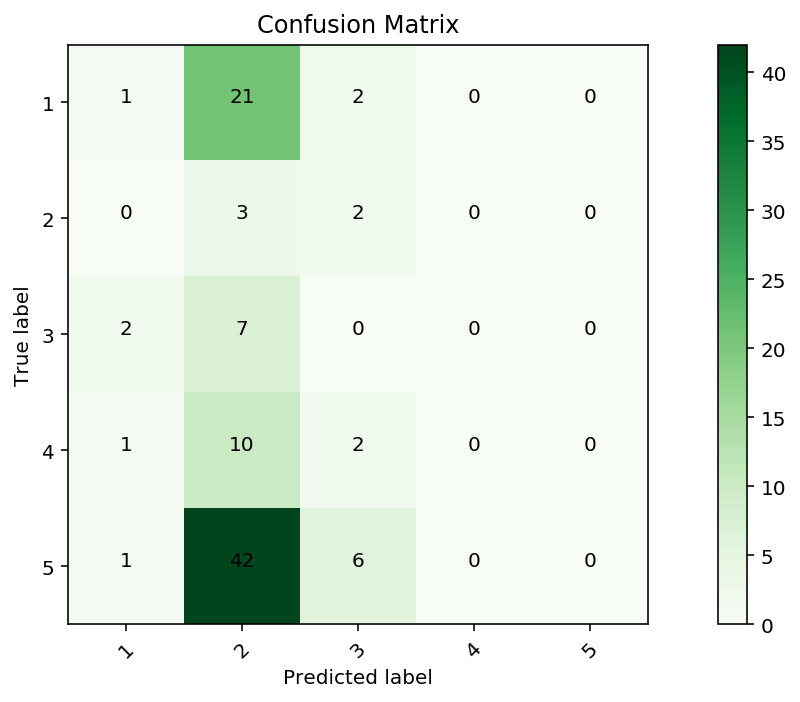

In [72]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()

In [73]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>